In [1]:
import pandas as pd
import numpy as np

import tensorflow as tf
from vaemols.models import VariationalAutoencoder
from vaemols.utils.utils import smiles_to_labels, labels_to_smiles, filter_smiles_to_mols

from rdkit import Chem
from rdkit.Chem import Draw

import logging

logging.basicConfig(level=logging.INFO)

char_data = np.load('data/char_data.npz')
int_to_char = char_data['int_to_char'].item()
char_to_int = char_data['char_to_int'].item()
num_classes = len(char_to_int)

max_length = 120

data = pd.read_csv('data/structures.csv', index_col=0)
smiles_data = list(data['structure'])
labeled_data = smiles_to_labels(smiles_data, char_to_int, max_length)

restore_model_dir = 'saved_models/'
restore_model_path = tf.train.latest_checkpoint(restore_model_dir)
logging.info(restore_model_path)

INFO:root:saved_models/weights-17-274.7396.ckpt


In [2]:
latent_dim = 256
inputs = tf.keras.layers.Input(shape=(max_length, num_classes))
vae = VariationalAutoencoder(latent_dim, num_classes, max_length, num_samples=1)
outputs = vae(inputs)

decoder_inputs = tf.keras.layers.Input(shape=(latent_dim,))
decoder_outputs = vae.decoder(decoder_inputs)

sess = tf.Session()
with sess.as_default():
    vae.load_weights(restore_model_path)

In [3]:
input_data = tf.keras.utils.to_categorical(labeled_data[:1], num_classes=num_classes)

num_samples = 300
std = 0.4

z_mean = sess.run(vae.z_mean, feed_dict={vae.input:input_data})
z_mean = np.tile(z_mean, (num_samples, 1))
z_samples = np.random.normal(loc=z_mean, scale=std, size=z_mean.shape)
outputs = sess.run(decoder_outputs[0], feed_dict={decoder_inputs:z_samples})

In [4]:
output_labels = np.argmax(outputs, axis=-1)
smiles = labels_to_smiles(output_labels, int_to_char)
valid_mols = filter_smiles_to_mols(smiles)

INFO:root:Number of input smiles: 300
INFO:root:Number of unique input smiles: 206
INFO:root:Number of unique valid mols: 48


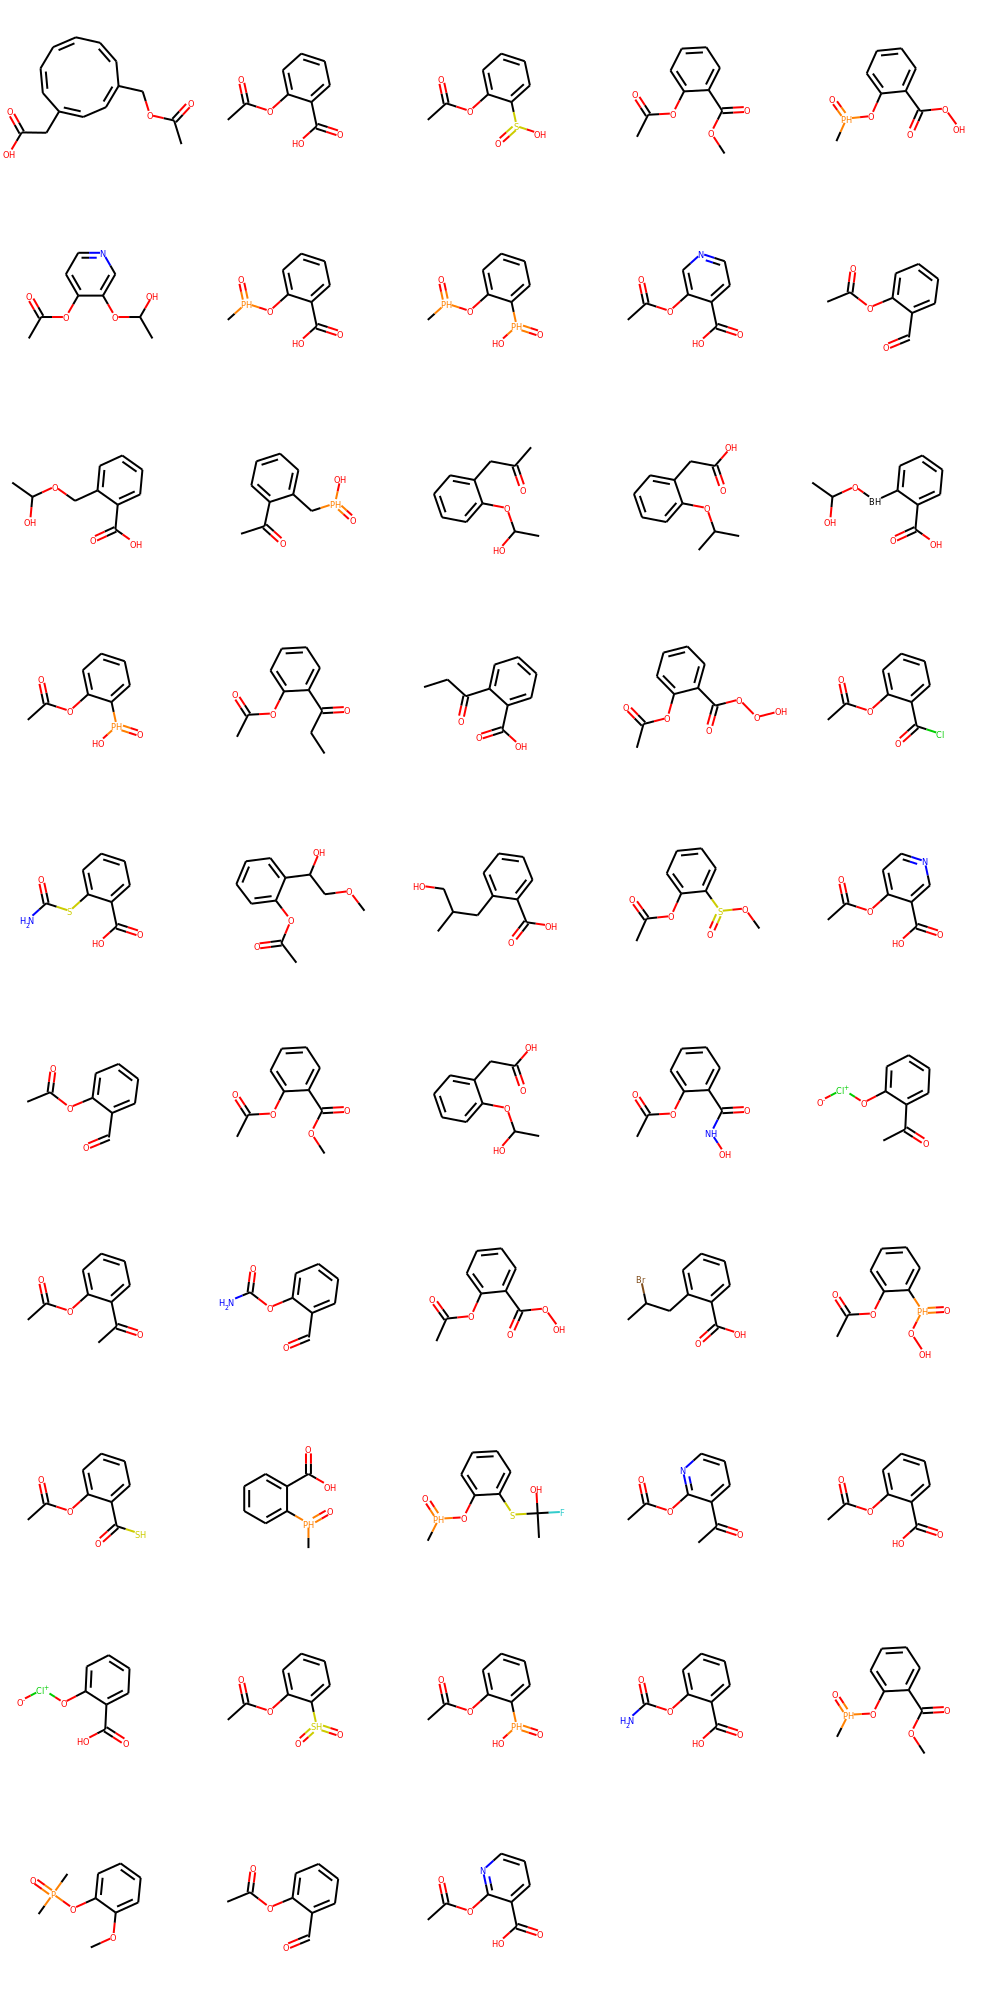

In [5]:
Draw.MolsToGridImage([mol for mol in valid_mols], molsPerRow=5)